In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import plotly.express as px
import seaborn as sns


In [2]:
df = pd.read_csv("/Users/sumiran/Downloads/preprocessed_dataset.csv")

# Separate features and target
y = df['marker']
X = df.drop('marker', axis=1) 

In [3]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# setting up the EDBN architecture
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_scaled.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# Train the model
history = model.fit(X_scaled, y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


2024-12-09 14:03:56.365062: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2573/2573 [==============================] - 4s 2ms/step - loss: 0.6542 - accuracy: 0.6252 - val_loss: 0.9149 - val_accuracy: 0.1113
Epoch 2/50
2573/2573 [==============================] - 4s 1ms/step - loss: 0.6375 - accuracy: 0.6499 - val_loss: 0.8694 - val_accuracy: 0.2455
Epoch 3/50
2573/2573 [==============================] - 4s 1ms/step - loss: 0.6212 - accuracy: 0.6678 - val_loss: 0.7836 - val_accuracy: 0.3781
Epoch 4/50
2573/2573 [==============================] - 4s 1ms/step - loss: 0.6028 - accuracy: 0.6817 - val_loss: 0.6231 - val_accuracy: 0.5069
Epoch 5/50
2573/2573 [==============================] - 4s 2ms/step - loss: 0.5814 - accuracy: 0.6956 - val_loss: 0.4842 - val_accuracy: 0.6799
Epoch 6/50
2573/2573 [==============================] - 5s 2ms/step - loss: 0.5637 - accuracy: 0.7065 - val_loss: 0.5903 - val_accuracy: 0.5572
Epoch 7/50
2573/2573 [==============================] - 4s 2ms/step - loss: 0.5481 - accuracy: 0.7184 - val_loss: 0.4585 - val_accuracy: 0.6941
Epo

In [29]:
# Predictions and evaluation metrics
y_pred_model = model.predict(X_scaled)
y_pred_model = (y_pred > 0.5).astype(int)

3216/3216 [==============================] - 2s 641us/step


In [30]:
# Confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix for EDBN:\n", cm)

Confusion Matrix for EDBN:
 [[48384  3061]
 [ 3906 47539]]


In [31]:
# Rule-based detection with dynamic thresholds
def dynamic_rule_based_detection(X, features=[0], threshold_percentile=90):

    rule_based_pred = np.zeros(X.shape[0], dtype=int)
    for feature in features:
        threshold = np.percentile(X[:, feature], threshold_percentile)
        rule_based_pred = rule_based_pred | (X[:, feature] > threshold).astype(int)  # Logical OR for multi-feature rules
    return rule_based_pred

In [32]:
# Rule-based predictions
rule_based_pred = dynamic_rule_based_detection(X_scaled, features=[0, 1, 2], threshold_percentile=90)

# Combined predictions: Model + Rule-Based
combined_pred = ((y_pred_model.flatten() == 1) | (rule_based_pred == 1)).astype(int)


              precision    recall  f1-score   support

           0       0.92      0.65      0.76     51445
           1       0.73      0.94      0.82     51445

    accuracy                           0.79    102890
   macro avg       0.82      0.79      0.79    102890
weighted avg       0.82      0.79      0.79    102890


Confusion Matrix:
[[33358 18087]
 [ 3053 48392]]


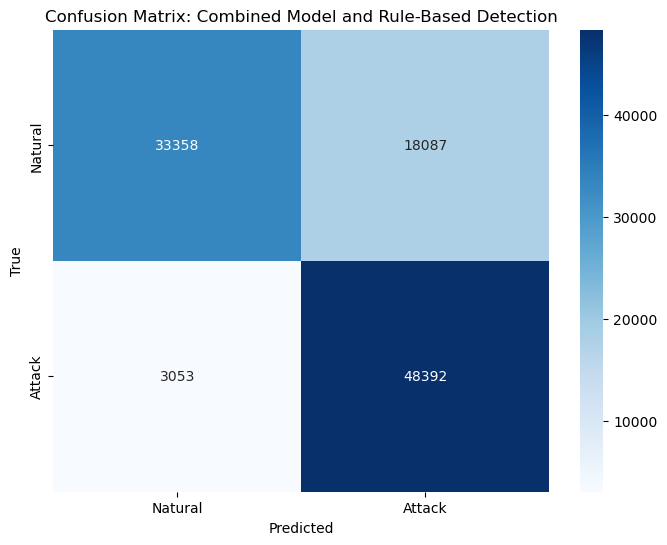

In [33]:
# Unified evaluation function
def evaluate_predictions(y_true, y_pred, title="Evaluation Metrics"):
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Natural', 'Attack'], yticklabels=['Natural', 'Attack'])
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate combined predictions
evaluate_predictions(y, combined_pred, title="Combined Model and Rule-Based Detection")

In [34]:
# # Rule-based detection 
# threshold = 0.5
# rule_based_pred = (X_scaled[:, 0] > threshold).astype(int)
# print(classification_report(y, rule_based_pred))
# cm_rule_based = confusion_matrix(y, rule_based_pred)
# print("Confusion Matrix for Rule-Based Detection:\n", cm_rule_based)

# Classification report
print("Classification Report:\n", classification_report(y, y_pred))

In [35]:
# Additional metrics
accuracy = accuracy_score(y, y_pred_model)
precision = precision_score(y, y_pred_model)
recall = recall_score(y, y_pred_model)
f1 = f1_score(y, y_pred_model)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.932286908348722
Precision: 0.939505928853755
Recall: 0.9240742540577316
F1 Score: 0.9317261992258318


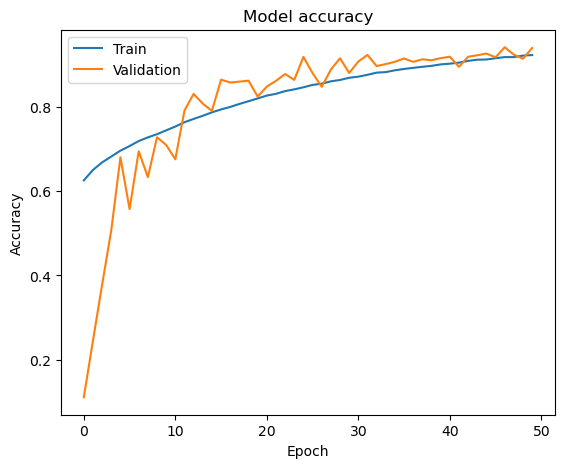

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

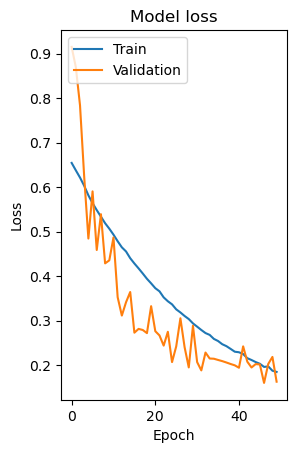

In [27]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

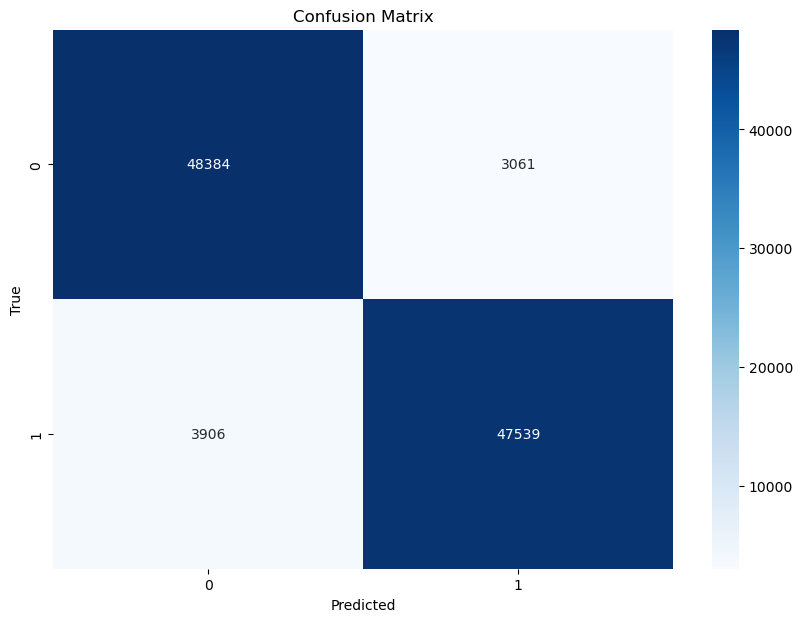

In [13]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()